In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras import layers, optimizers, datasets, models, utils, losses, callbacks
import keras.backend as K
from scipy.spatial.distance import euclidean
from sklearn.cluster import KMeans
from tqdm import tqdm

%matplotlib inline

Using TensorFlow backend.


In [2]:
# load the mnist dataset
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

In [3]:
x_train = np.expand_dims(x_train, axis=3) / 255

In [4]:
x_train.shape

(60000, 28, 28, 1)

In [5]:
# y_train = utils.to_categorical(num_classes=10, y=y_train)

In [6]:
# y_train.shape

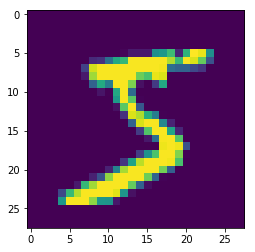

In [7]:
plt.imshow(x_train[0].reshape(28,28))

## Encoder

In [8]:
import tensorflow as tf

In [9]:
tf.__version__

'1.8.0'

## Network Architecture

### Initialize the CNN

In [10]:
# - - - input image - - -
# 28x28x1
image_input = layers.Input(shape=(28,28,1))


# - - - CNN - - - 
# first convolution
# 14x14x32
conv_1 = layers.Conv2D(filters=32, kernel_size=(2,2), strides=(2,2), 
                       activation="relu", padding="valid", name="conv_1")(image_input)

# second convolution
# 7x7x64
conv_2 = layers.Conv2D(filters=64, kernel_size=(2,2), strides=(2,2), 
                       activation="relu", padding="valid", name="conv_2")(conv_1)
# - - - CNN - - - 


# - - - Adaptation Layers - - -
ada_3 = layers.Conv2D(filters=128, kernel_size=(2,2), strides=(2,2),
                     activation="relu", padding="same", name="ada_1")(conv_2)

ada_4 = layers.Conv2D(filters=10, kernel_size=(2,2), strides=(2,2),
                     activation="relu", padding="same", name="ada_2")(ada_3)
# - - - Adaptation Layers - - - 


# - - - Global Pool - - -
global_max_pool = layers.GlobalMaxPool2D()(ada_4)
# - - - Global Pool - - -


# - - - FC9 - - -
fc = layers.Dense(units=10, activation='relu', name='fc')(global_max_pool)
# - - - FC9 - - -


# - - - SOFTMAX - - -
softmax = layers.Dense(units=10, activation='softmax', name='softmax')(fc)
# - - - SOFTMAX - - - 

### Forward pass of the K randomly selected images

In [11]:
# choose K - (10) random images out of the set to use as initial cluster centroids
index_list = np.arange(len(x_train))

# get 10 random indices
random_indices = np.random.choice(a=index_list, size=10, replace=False)

# get the corresponding 10 images
initial_random_images = x_train[random_indices]

In [12]:
# define the K.function to get the centroids
ccnn_function = K.function(inputs=[image_input], outputs=[softmax])

# get the initial centroids
initial_centroids_features = ccnn_function([initial_random_images])[0]

# get the labels of the initial centroids
# ARGMAX since softmax outputs the probabilities
ccnn_initial_labels = np.argmax(initial_centroids_features, 1)

print(ccnn_initial_labels)

[5 5 5 5 5 5 5 5 5 5]


### Forward pass of the rest of the data

In [13]:
# create the mask to drop the initial indices
mask = np.ones(shape=index_list.shape)
mask[random_indices] = False

# get the other images tensor
other_images = x_train[mask.astype(np.bool)]

In [14]:
# forward pass the rest of the images
other_images_features = ccnn_function([other_images])[0]

In [15]:
# get the labels of the other images based on the CNN
other_images_labels_cnn = np.argmax(other_images_features, 1)

In [38]:
# get the labels of the other images based on how close they are to the initial k images
other_images_labels_kmeans = np.array([np.argmin(np.square([euclidean(u=centroid, v=feature) for centroid in initial_centroids_features])) for feature in other_images_features])

In [77]:
# assign clusters function
def assign_clusters(population, labels):
    clusters = list()
    counts = list()
    for i in range(10):
        clusters.append(population[labels==i])
        counts.append(len(population[labels==i]))
    return np.array(clusters), np.array(counts)

In [78]:
# get the clusters
clusters, counts = assign_clusters(other_images, other_images_labels_kmeans)

# get gammas
gammas = 1 / counts

In [79]:
gammas

array([0.00032552, 0.00053706, 0.00016215, 0.00011266, 0.00015743,
       0.00011682, 0.00018002, 0.00015466, 0.0001261 , 0.00019417])

In [35]:
initial_centroids_features

array([[0.10045008, 0.10724869, 0.09941763, 0.09242852, 0.09693871,
        0.10876527, 0.1009519 , 0.09527495, 0.09941535, 0.09910887],
       [0.09992541, 0.10478106, 0.10118383, 0.0939213 , 0.09700783,
        0.10583025, 0.1030646 , 0.09574567, 0.09975309, 0.09878699],
       [0.10042609, 0.10183724, 0.10010215, 0.09679455, 0.09908783,
        0.10298848, 0.10010608, 0.09841885, 0.1007    , 0.09953874],
       [0.10006337, 0.10267527, 0.10077581, 0.09489261, 0.09771559,
        0.10446461, 0.10157785, 0.09804267, 0.10113981, 0.09865239],
       [0.10003076, 0.10438261, 0.10049063, 0.09429134, 0.09713965,
        0.10549877, 0.10191015, 0.09708996, 0.0999963 , 0.09916976],
       [0.09984685, 0.10503259, 0.09944881, 0.09327354, 0.09694659,
        0.10684235, 0.09990719, 0.09799623, 0.10174733, 0.09895865],
       [0.10047275, 0.10578577, 0.09985535, 0.09377382, 0.09443211,
        0.10689691, 0.10409394, 0.09689356, 0.09834962, 0.09944613],
       [0.10070892, 0.1041219 , 0.0988730

### Train the CNN

In [17]:
# one hot encode the labels
other_images_labels_kmeans_onehot = utils.to_categorical(y=other_images_labels_kmeans, num_classes=10)
other_images_labels_cnn_onehot = utils.to_categorical(y=other_images_labels_cnn, num_classes=10)

In [18]:
other_images_labels_cnn_onehot[:5]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

In [19]:
other_images_labels_kmeans_onehot[:5]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

In [20]:
# define the keras model
model = models.Model(inputs=image_input, outputs=softmax)

# define metrics
metrics = ["accuracy"]

# define callbacks
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
callbacks_ = [early_stopping]

# compile the model
model.compile(loss=losses.categorical_crossentropy, optimizer=optimizers.SGD(lr=0.001), metrics=metrics)

# fit the model
model.fit(x=other_images, y=other_images_labels_kmeans_onehot, validation_split=0.20, epochs=10, verbose=1, callbacks=callbacks_)

Train on 47992 samples, validate on 11998 samples
Epoch 1/10
47992/47992 [==============================] - 21s 434us/step - loss: 2.2834 - acc: 0.1495 - val_loss: 2.2706 - val_acc: 0.1438
Epoch 2/10
47992/47992 [==============================] - 17s 360us/step - loss: 2.2602 - acc: 0.1426 - val_loss: 2.2484 - val_acc: 0.1434
Epoch 3/10
47992/47992 [==============================] - 16s 335us/step - loss: 2.2381 - acc: 0.1425 - val_loss: 2.2248 - val_acc: 0.1434
Epoch 4/10
47992/47992 [==============================] - 16s 331us/step - loss: 2.2110 - acc: 0.1441 - val_loss: 2.1931 - val_acc: 0.1513
Epoch 5/10
47992/47992 [==============================] - 16s 327us/step - loss: 2.1711 - acc: 0.1688 - val_loss: 2.1443 - val_acc: 0.1969
Epoch 6/10
47992/47992 [==============================] - 16s 327us/step - loss: 2.1088 - acc: 0.2366 - val_loss: 2.0693 - val_acc: 0.2814
Epoch 7/10
47992/47992 [==============================] - 16s 331us/step - loss: 2.0222 - acc: 0.3352 - val_loss: 1.

### Update the centroids

In [42]:
# old centroids are initial random centroids
new_features = ccnn_function([x_train])[0]

assign_clusters(labels=)

In [82]:
new_features_labels_kmeans = np.array([np.argmin(np.square([euclidean(u=centroid, v=feature) 
                                                            for centroid in initial_centroids_features])) 
                                       for feature in new_features])

In [83]:
assign_clusters(new_features, new_features_labels_kmeans)

(array([array([[3.0271928e-13, 9.9371147e-01, 1.3544607e-07, ..., 2.2013427e-15,
         4.4605062e-32, 2.4998013e-15],
        [5.8251684e-16, 9.9989748e-01, 9.3301822e-10, ..., 3.0013701e-21,
         1.9749419e-37, 2.4754146e-13],
        [5.6486736e-27, 9.9977177e-01, 2.2826542e-04, ..., 3.5428783e-14,
         4.1846095e-28, 5.4270752e-09],
        ...,
        [4.3052052e-11, 9.1309220e-01, 4.6314560e-02, ..., 1.1433909e-07,
         1.9020744e-23, 1.1400284e-11],
        [1.3490844e-14, 9.3835515e-01, 6.1226439e-02, ..., 1.3700715e-07,
         5.3405797e-21, 2.6691287e-09],
        [4.0583309e-12, 9.9305677e-01, 5.2689834e-06, ..., 7.8028267e-10,
         1.2839010e-22, 8.5652423e-12]], dtype=float32),
        array([[1.5657682e-18, 6.4390339e-02, 9.3560296e-01, ..., 5.9099953e-06,
         8.0431755e-19, 2.8349351e-08],
        [1.4065014e-23, 7.1102608e-05, 9.9907279e-01, ..., 8.5573184e-04,
         6.3414636e-16, 7.1332330e-08],
        [3.8415689e-15, 4.8885614e-02, 9.510

### Forward pass the images

In [21]:
for t in tqdm(range(10)):
    
    # get the new feature vector by forward pass of the CNN
    new_features = ccnn_function([x_train])[0]
    
    # form new clusters
    kmeans = KMeans(n_clusters=10).fit(new_features)
    
    # get the new labels
    labels_kmeans_onehot = utils.to_categorical(y=kmeans.labels_, num_classes=10)
    
    # fit the model
    model.fit(x=x_train, y=labels_kmeans_onehot, 
              validation_split=0.20, epochs=10, verbose=0, 
              callbacks=callbacks_)

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [24:58<00:00, 149.90s/it]


In [22]:
random_indices = np.random.choice(np.arange(len(x_train)), replace=False, size=100)

In [23]:
random_images = x_train[random_indices]

In [24]:
true_labels = y_train[random_indices]

In [25]:
predicted_labels = np.argmax(ccnn_function([random_images])[0], 1)

In [26]:
predicted_labels

array([1, 1, 2, 6, 1, 5, 2, 1, 3, 2, 3, 0, 6, 2, 0, 2, 3, 6, 5, 3, 1, 7,
       1, 1, 1, 1, 7, 6, 1, 1, 2, 3, 2, 1, 0, 1, 6, 5, 6, 2, 3, 2, 5, 2,
       2, 6, 3, 3, 1, 1, 6, 0, 5, 6, 5, 5, 0, 3, 1, 2, 1, 1, 1, 2, 6, 6,
       5, 1, 6, 0, 6, 2, 2, 0, 6, 2, 6, 4, 6, 2, 3, 5, 0, 1, 1, 1, 3, 2,
       3, 6, 3, 1, 2, 3, 0, 2, 2, 2, 3, 1], dtype=int64)

In [27]:
true_labels

array([3, 3, 3, 4, 0, 5, 9, 5, 2, 3, 1, 1, 7, 8, 7, 5, 8, 6, 5, 7, 2, 4,
       3, 2, 6, 4, 9, 8, 3, 3, 0, 9, 8, 3, 1, 5, 7, 9, 3, 3, 1, 9, 0, 3,
       0, 7, 7, 1, 2, 2, 7, 7, 5, 7, 4, 5, 1, 2, 4, 8, 6, 0, 6, 0, 4, 4,
       5, 8, 7, 7, 4, 3, 8, 1, 6, 5, 7, 6, 9, 3, 1, 5, 1, 2, 6, 0, 5, 5,
       2, 7, 5, 4, 4, 1, 7, 0, 4, 8, 8, 8], dtype=uint8)

In [28]:
true_labels == predicted_labels

array([False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [ ]:
plt.imshow(random_images[0].reshape(28,28))